# Simulated DCA Demo

In [1]:
from hyppo.tools import SIMULATIONS
from matplotlib import cm
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import pickle

import dist_cov as dc

In [2]:
np.random.seed(7)

# DCA Feature Selection

Given a $(N \times P)$ matrix $X$ with $N$ samples and $P$ features, a $(N \times 1)$ matrix Y, and a dimensionality target $K$, select the $K$ dimensions of $X$ with the highest distance covariance to obtain $\hat{X}$. Ideally, $\hat{X}$ is the $(N \times K)$ matrix that is the best predictor of $Y$.

## nD Simulated Linear Independence Data

### Initialize Data

In [3]:
lin_sim = SIMULATIONS["linear"]
X, Y = lin_sim(100, 10, noise=True)
D_X = dc.dist_mat(X)
D_Y = dc.dist_mat(Y)
R_X = dc.re_centered_dist(D_X)
R_Y = dc.re_centered_dist(D_Y)
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
D_u = dc.dist_mat_vec(X[:, 0])
R_X_u = dc.re_centered_dist(D_u)

X shape: (100, 10)
Y shape: (100, 1)


### Test Function Dimension Alignment

In [4]:
v = dc.dist_cov_sq(R_X, R_Y)
print(f"v^2: {v}")

v^2: 2.9315010626047187


### DCA

In [5]:
print(f"X shape: {X.shape}")
print(f"X:\n{X[:5]}")
X_reduced = dc.dca(X, Y, K=3)
print(f"X_reduced shape: {X_reduced.shape}")
print(f"X_reduced:\n{X_reduced[:5]}")

X shape: (100, 10)
X:
[[-8.47383421e-01  5.59837584e-01 -1.23181537e-01  4.46930356e-01
   9.55979024e-01  7.69917408e-02  2.24092732e-03 -8.55897733e-01
  -4.63122040e-01 -2.34998349e-04]
 [ 3.58459992e-01  6.07478072e-01 -2.38117734e-01 -8.68127306e-01
  -4.23708801e-01  8.19187055e-01 -5.73229293e-01 -9.57520764e-02
   8.62412039e-01 -9.50201545e-01]
 [ 2.01097835e-01  9.00259001e-01 -5.39394242e-01  9.69798385e-02
   8.18256750e-01 -7.33661108e-01  4.68251613e-02  5.00819718e-01
   3.38026482e-01 -6.44942805e-02]
 [-5.90301819e-01 -1.84682218e-02 -2.55230621e-01 -4.51976903e-02
  -2.68219228e-01  6.75835989e-01  5.37295013e-01 -3.72010646e-01
   1.45250665e-01 -4.47901903e-01]
 [-9.43141349e-02 -2.94043268e-01  3.14798926e-01 -2.59297834e-01
  -8.18140442e-02  4.38648245e-01 -1.74016342e-01  8.12846538e-01
  -6.39096762e-01  4.82237746e-01]]
X_reduced shape: (100, 3)
X_reduced:
[[-0.84738342  0.07699174  0.55983758]
 [ 0.35845999  0.81918706  0.60747807]
 [ 0.20109783 -0.73366111  

# DCA with Gradient-Based Learning Approach

Given a $(N \times P)$ matrix $X$ with $N$ samples and $P$ features, a $(N \times 1)$ matrix Y, and a dimensionality target $K$, use gradient descent to learn a $(P \times K)$ matrix $U$ such that $X U = \hat{X}$. $U$ is composed of $K$ learned vectors $u_i$ such that each $u_i$ maximizes distance covariance with some orthonormal basis of $X$. Ideally, $\hat{X}$ is the $(N \times K)$ matrix that is the best predictor of $Y$.

## 1D Simulated Linear Independence Data

### Plot Dataset

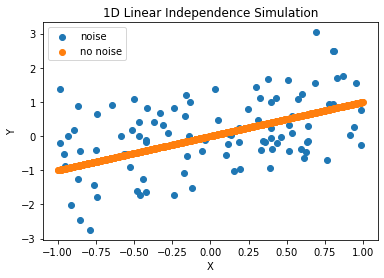

In [6]:
lin_sim = SIMULATIONS["linear"]
lin_x_n, lin_y_n = lin_sim(100, 1, noise=True)
lin_x, lin_y = lin_sim(1000, 1)
plt.scatter(lin_x_n, lin_y_n)
plt.scatter(lin_x, lin_y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("1D Linear Independence Simulation")
plt.legend(["noise", "no noise"]);

### Initialize Data

In [7]:
X, Y = lin_sim(10, 1, noise=True)
D_X = dc.dist_mat(X)
D_Y = dc.dist_mat(Y)
R_X = dc.re_centered_dist(D_X)
R_Y = dc.re_centered_dist(D_Y)
u = np.random.rand(X.shape[1])
u_normalized_norm = LA.norm(dc.normalize_u(u))
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
print(f"u: {u}")
print(f"u norm: {u_normalized_norm}")
D_u = dc.dist_mat_u(u, X)
R_X_u = dc.re_centered_dist(D_u)

X shape: (10, 1)
Y shape: (10, 1)
u: [0.92089854]
u norm: 1.0


### Test Function Dimension Alignment

In [8]:
du = dc.dist_cov_sq_grad(u, X, R_Y)
print(f"dvdu: {du}")
v = dc.dist_cov_sq(R_X, R_Y)
print(f"v^2: {v}")

dvdu: [-12.30224005]
v^2: 0.7983470901938798


### Optimize $u$

In [9]:
v_u = dc.dist_cov_sq(R_Y, R_X_u)
print(f"v^2_u: {v_u}")
u_opt, v_opt = dc.optim_u_gd(u, X, R_Y, 1e-3, 1e-5)
print(f"u opt: {u_opt}")
print(f"v^2_u_opt: {v_opt}")

v^2_u: 0.7351966702389796
u opt: [1.]
v^2_u_opt: 0.7983470901938798


### Plot Gradient Ascent

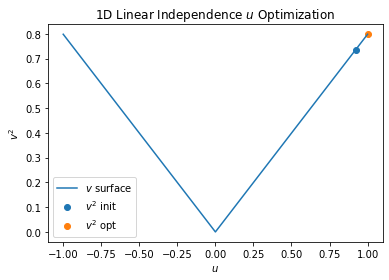

In [10]:
u_plt = np.expand_dims(np.linspace(-1, 1, 11), 1)
v_u_plt = np.zeros_like(u_plt)
for i in range(u_plt.shape[0]):
    D_u_i = dc.dist_mat_u(u_plt[i], X)
    R_X_u_i = dc.re_centered_dist(D_u_i)
    v_u_i = dc.dist_cov_sq(R_Y, R_X_u_i)
    v_u_plt[i] = v_u_i
plt.plot(u_plt, v_u_plt)
plt.scatter([u], [v_u])
plt.scatter([u_opt], [v_opt])
plt.xlabel(r"$u$")
plt.ylabel(r"$v^2$")
plt.title(r"1D Linear Independence $u$ Optimization")
plt.legend([r'$v$ surface', r'$v^2$ init', r'$v^2$ opt']);

## 2D Simulated Linear Independence Data

### Plot Dataset

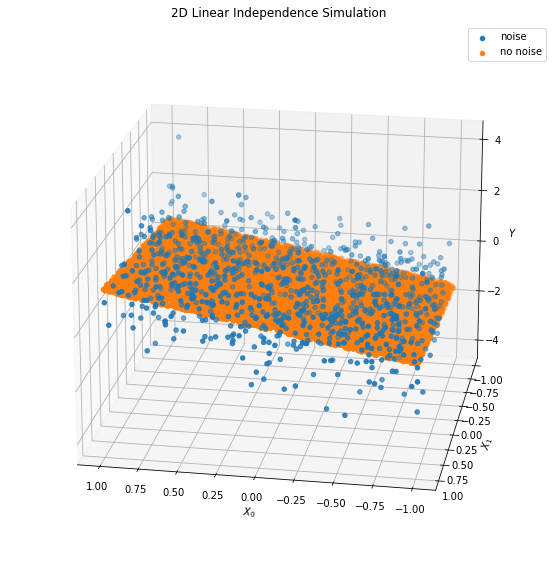

In [11]:
lin_sim = SIMULATIONS["linear"]
lin_x_n, lin_y_n = lin_sim(1000, 2, noise=True)
lin_x, lin_y = lin_sim(10000, 2)

lin_x_1_n = lin_x_n[:, 0]
lin_x_2_n = lin_x_n[:, 1]
lin_x_1 = lin_x[:, 0]
lin_x_2 = lin_x[:, 1]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(lin_x_1_n, lin_x_2_n, lin_y_n)
ax.scatter(lin_x_1, lin_x_2, lin_y)
ax.set_xlabel(r"$X_0$")
ax.set_ylabel(r"$X_1$")
ax.set_zlabel(r"$Y$")
plt.title("2D Linear Independence Simulation")
plt.legend(["noise", "no noise"])
ax.view_init(elev=20, azim=100);

### Initialize Data

In [12]:
X, Y = lin_sim(10, 2, noise=True)
D_X = dc.dist_mat(X)
D_Y = dc.dist_mat(Y)
R_X = dc.re_centered_dist(D_X)
R_Y = dc.re_centered_dist(D_Y)
u = np.random.rand(X.shape[1])
u = dc.normalize_u(u)
u_norm = LA.norm(u)
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
print(f"u: {u}")
print(f"u norm: {u_norm}")
D_u = dc.dist_mat_u(u, X)
R_X_u = dc.re_centered_dist(D_u)

X shape: (10, 2)
Y shape: (10, 1)
u: [0.73753922 0.6753043 ]
u norm: 1.0


### Test Function Dimension Alignment

In [13]:
du = dc.dist_cov_sq_grad(u, X, R_Y)
print(f"dvdu: {du}")
v = dc.dist_cov_sq(R_X, R_Y)
print(f"v^2: {v}")

dvdu: [-9.09639831 -3.57904363]
v^2: 1.0502153241869034


### Optimize $u$

In [14]:
v_u = dc.dist_cov_sq(R_Y, R_X_u)
print(f"v^2_u: {v_u}")
u_opt, v_opt = dc.optim_u_gd(u, X, R_Y, 1e-3, 1e-5)
print(f"u opt: {u_opt}")
print(f"v^2_u_opt: {v_opt}")

v^2_u: 0.5248342592729863
u opt: [ 0.79073743 -0.61215547]
v^2_u_opt: 0.8520150702051481


### Plot Gradient Ascent

In [15]:
surf_res = 1e-1
X_surf = np.arange(-1, 1, surf_res)
Y_surf = np.arange(-1, 1, surf_res)
X_surf, Y_surf = np.meshgrid(X_surf, Y_surf)
v_u_plt = np.zeros_like(X_surf)
for i in range(X_surf.shape[0]):
    for j in range(X_surf.shape[1]):
        D_u_i = dc.dist_mat_u(np.array([X_surf[i, j], Y_surf[i, j]]), X)
        R_X_u_i = dc.re_centered_dist(D_u_i)
        v_u_i = dc.dist_cov_sq(R_Y, R_X_u_i)
        v_u_plt[i, j] = v_u_i

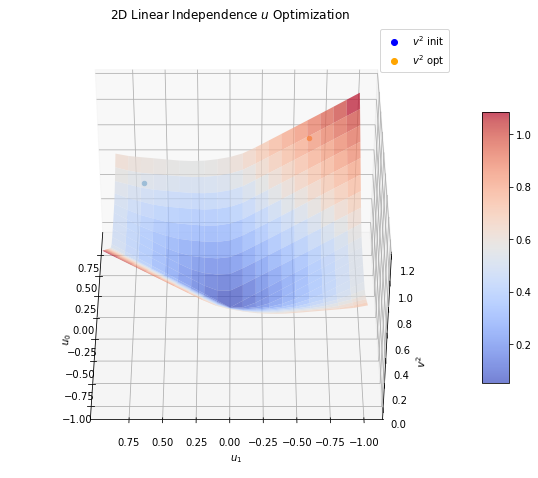

In [16]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
surf = ax.plot_surface(X_surf, Y_surf, v_u_plt, cmap=cm.coolwarm, linewidth=0, antialiased=True, alpha=.7)
ax.scatter([u[0]], [u[1]], [v_u])
ax.scatter([u_opt[0]], [u_opt[1]], [v_opt])
ax.set_xlabel(r"$u_0$")
ax.set_ylabel(r"$u_1$")
ax.set_zlabel(r"$v^2$")
ax.set_title(r"2D Linear Independence $u$ Optimization")
init_proxy = Line2D([0], [0], linestyle="none", c='blue', marker='o')
opt_proxy = Line2D([0], [0], linestyle="none", c='orange', marker='o')
ax.legend([init_proxy, opt_proxy], [r"$v^2$ init", r"$v^2$ opt"], numpoints=1)
fig.colorbar(surf, shrink=0.5, aspect=10)
ax.view_init(elev=40, azim=180);

## nD Simulated Linear Independence Data

### Initialize Data

In [17]:
lin_sim = SIMULATIONS["linear"]
X, Y = lin_sim(100, 10, noise=True)
D_X = dc.dist_mat(X)
D_Y = dc.dist_mat(Y)
R_X = dc.re_centered_dist(D_X)
R_Y = dc.re_centered_dist(D_Y)
u = np.random.rand(X.shape[1])
u = dc.normalize_u(u)
u_norm = LA.norm(u)
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
print(f"u: {u}")
print(f"u norm: {u_norm}")
D_u = dc.dist_mat_u(u, X)
R_X_u = dc.re_centered_dist(D_u)

X shape: (100, 10)
Y shape: (100, 1)
u: [0.41065767 0.1849266  0.28933188 0.11158955 0.10234402 0.50651914
 0.15737465 0.59643778 0.22765772 0.04035455]
u norm: 1.0


### Test Function Dimension Alignment

In [18]:
du = dc.dist_cov_sq_grad(u, X, R_Y)
print(f"dvdu: {du}")
v = dc.dist_cov_sq(R_X, R_Y)
print(f"v^2: {v}")

dvdu: [-66.51201061 -23.99664434 -60.84697441 -49.00267561 -17.45714826
 -69.7054558  -29.45208648 -92.33369167 -30.64892463  13.41739069]
v^2: 3.394061556542055


### Optimize $u$

In [19]:
v_u = dc.dist_cov_sq(R_Y, R_X_u)
print(f"v^2_u: {v_u}")
u_opt, v_opt = dc.optim_u_gd(u, X, R_Y, 1e-3, 1e-5)
print(f"u opt: {u_opt}")
print(f"v^2_u_opt: {v_opt}")

v^2_u: 0.8484900893447975
u opt: [-0.1573134  -0.58794296  0.44736306  0.32176311  0.00483658 -0.11200707
  0.2648696   0.13738867  0.47284706  0.02693484]
v^2_u_opt: 1.1365465645998132


### DCA

In [20]:
print(f"X shape: {X.shape}")
print(f"X:\n{X[:5]}")
U, v_dca = dc.dca_grad_learn(X, Y, K=3, lr=1e-3, epsilon=1e-5)
print(f"U shape: {U.shape}")
print(f"U:\n{U}")
print(f"v shape: {v_dca.shape}")
print(f"v: {v_dca}")
X_reduced = X @ U
print(f"X_reduced shape: {X_reduced.shape}")
print(f"X_reduced:\n{X_reduced[:5]}")

X shape: (100, 10)
X:
[[-0.08585215 -0.76763335  0.73671604  0.9600785  -0.44611893  0.7209354
   0.53972082  0.15223509  0.2930756   0.38407111]
 [ 0.31676659  0.74363751  0.1405053   0.01081367 -0.11496449 -0.39673035
  -0.34446833 -0.98429696 -0.79240454  0.82930607]
 [ 0.82108865 -0.63450135  0.07850965  0.97022455  0.69417509 -0.06135703
  -0.84142639 -0.46248427 -0.33512451  0.06241334]
 [-0.36829948 -0.34262234  0.88948479  0.73606238  0.81583999  0.22853835
   0.68717114  0.63595424  0.57870259  0.4289705 ]
 [ 0.45347397  0.79582656 -0.49379134  0.68964624 -0.05111709  0.94219761
  -0.61083191 -0.96093017  0.18775375  0.44545912]]
U shape: (10, 3)
U:
[[-0.03111731  0.04142743  0.05100318]
 [-0.47852392  0.23907871  0.04309993]
 [ 0.44252727  0.54638291  0.08566654]
 [ 0.49023888  0.14442551  0.10325997]
 [-0.04874821  0.43594232  0.87187655]
 [-0.01557249  0.30148237  0.29596732]
 [ 0.29136295  0.12557966  0.25247294]
 [ 0.02695229  0.13813088  0.13916094]
 [ 0.48926944  0.5408

# Replicate Figure 2 from Cowley

## DCA with gradient-based learning

In [21]:
def unit_vec(v):
    return v / LA.norm(v)

def vec_angle(v0, v1):
    """
    Radians
    """
    u0 = unit_vec(v0)
    u1 = unit_vec(v1)
    return np.arccos(np.clip(np.dot(u0, u1), -1., 1.))

def beta_angle(beta_hat, beta):
    """
    Mean of all beta_i vectors (P x 1)
    """
    angle = 0
    b = beta_hat.shape[1]
    for i in range(b):
        v0 = beta_hat[:, i]
        v1 = beta[:, i]
        angle += vec_angle(v0, v1)
    return angle / b

def generate_data(N, P, b, f):
    """
    N: number of samples
    P: number of features
    b: number of dimensions identified from dimensionality reduction
    f: degree of nonlinearity
    returns
        X: (N x P): (feature x sample), x_i: (N x 1)
        beta: (P x b), beta_i: (P x 1)
        Y: (N x b), y_i: (N x 1)
    """
    X = np.random.normal(size=(N, P))
    alpha = 8 * np.sqrt(P) * LA.norm(X, ord=np.inf) # normalization constant
    
    plt.figure()
    x_range_plot = np.arange(-np.pi/4, np.pi/4, .01)
    plt.plot(x_range_plot, np.sin(2 * np.pi / alpha * f * x_range_plot))
    plt.plot(x_range_plot, x_range_plot)
    plt.title(f"f: {f}, alpha: {alpha}")
    plt.legend(['data', 'linear'])
    ax = plt.gca()
    ax.set_xlim([-np.pi/4, np.pi/4])
    ax.set_ylim([-1, 1])
    plt.show()
    
    beta, _ = LA.qr(np.random.normal(size=(P, b)))
    Y = np.zeros((N, b))
    for i in range(b):
        Y[:, i] = np.sin(2 * np.pi / alpha * f * X @ beta[:, i]) # (N x P) @ (P x 1) = (N x 1)
    return X, beta, Y

trial: 0


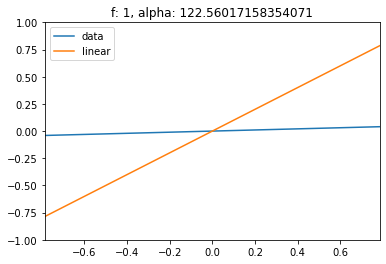

beta angle: 122.01197699861224 deg


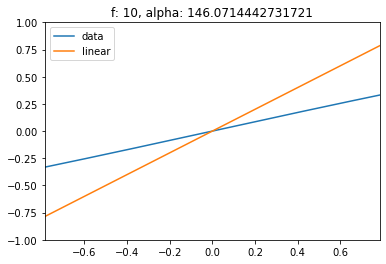

beta angle: 113.9955548961564 deg


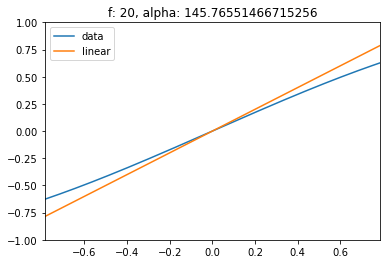

beta angle: 91.41508023444938 deg


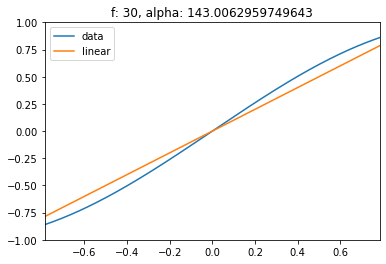

beta angle: 125.38905074543607 deg


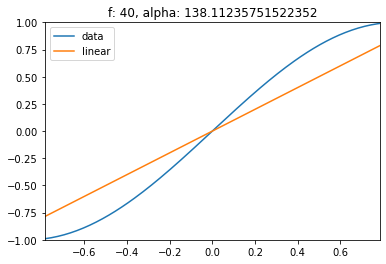

beta angle: 91.02577520858485 deg


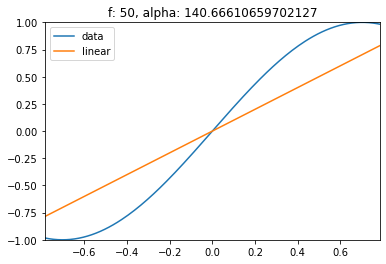

beta angle: 108.42026375190002 deg


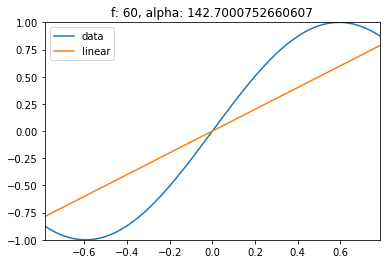

beta angle: 121.10493784467202 deg


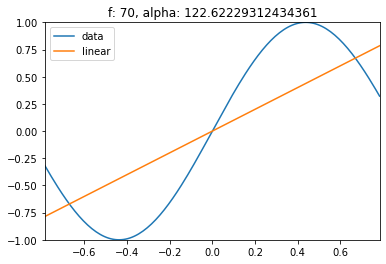

beta angle: 81.57880251082273 deg


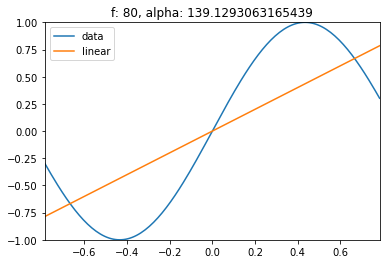

beta angle: 105.99863171826625 deg


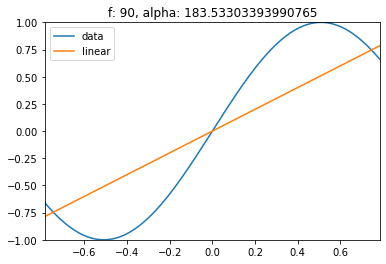

beta angle: 87.21705885266596 deg


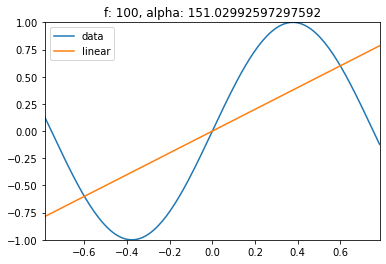

beta angle: 78.43735780300864 deg


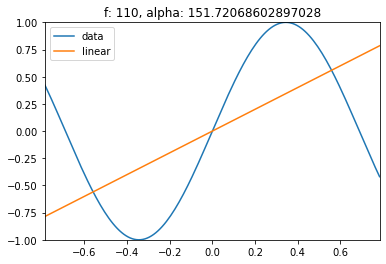

beta angle: 133.33661145715647 deg


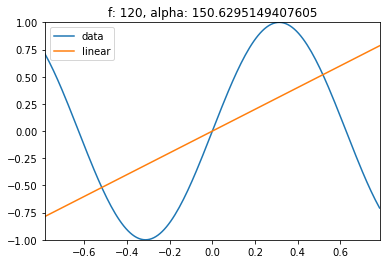

beta angle: 85.36440238524682 deg
trial: 1


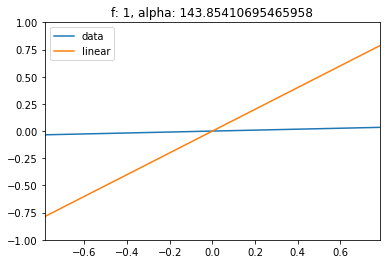

beta angle: 84.46596028351726 deg


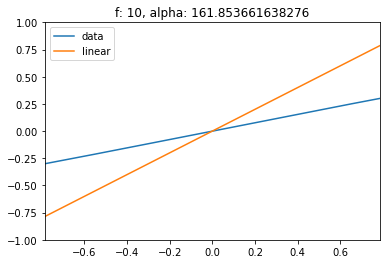

beta angle: 128.35188501395785 deg


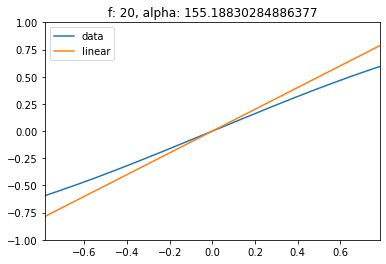

beta angle: 98.64385559162075 deg


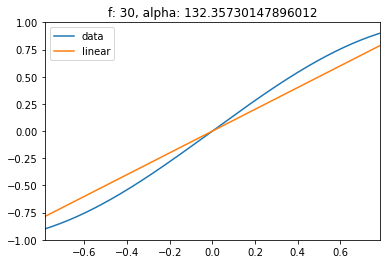

beta angle: 85.63382359655606 deg


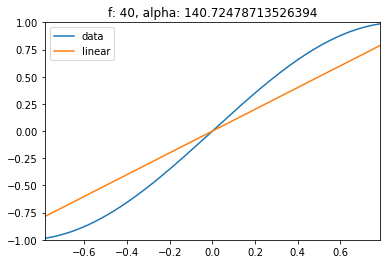

beta angle: 103.12486749569045 deg


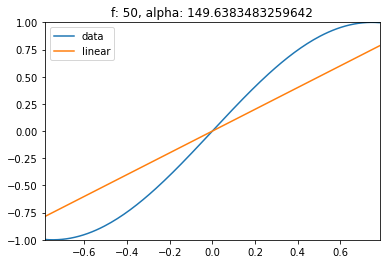

beta angle: 58.323170028795715 deg


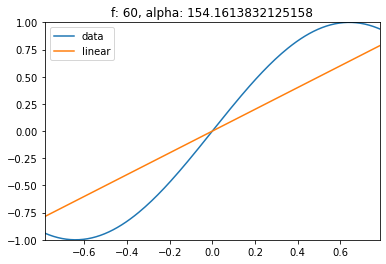

beta angle: 112.94070489735455 deg


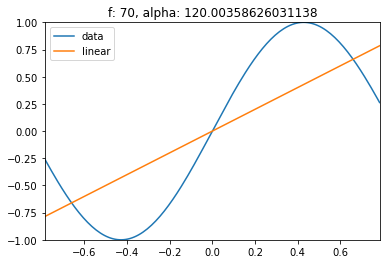

beta angle: 119.3594423171276 deg


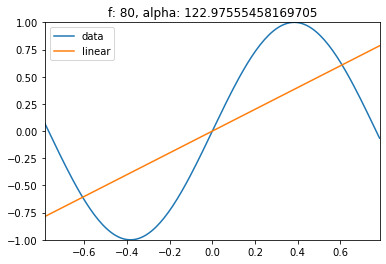

beta angle: 123.50921220103073 deg


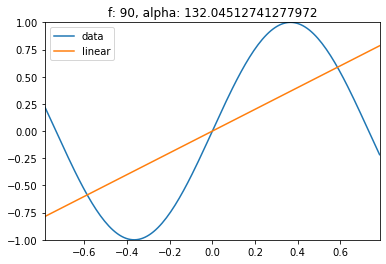

beta angle: 57.99496852849677 deg


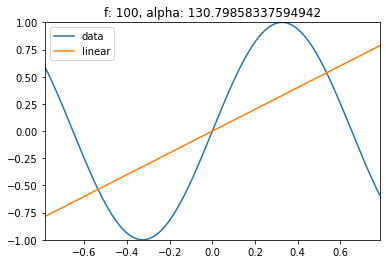

beta angle: 100.09719202050765 deg


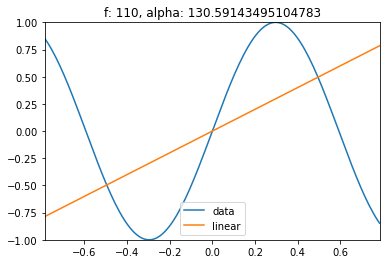

beta angle: 97.28211424707418 deg


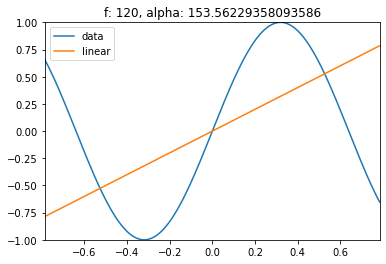

beta angle: 104.56674061536604 deg
trial: 2


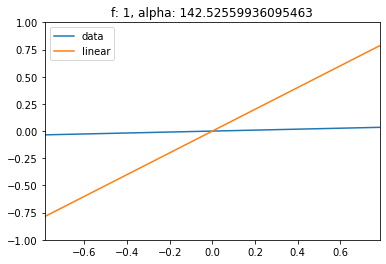

beta angle: 62.29604336547242 deg


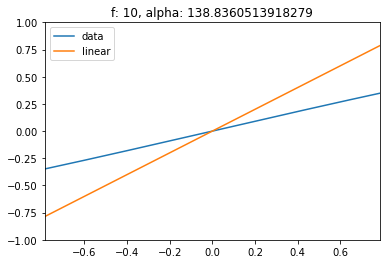

beta angle: 80.84213903471644 deg


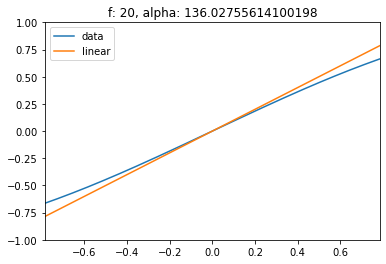

beta angle: 89.32499304669076 deg


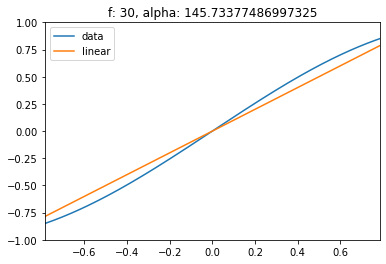

beta angle: 85.78650387414946 deg


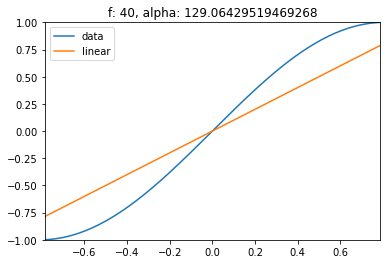

beta angle: 92.92846308723226 deg


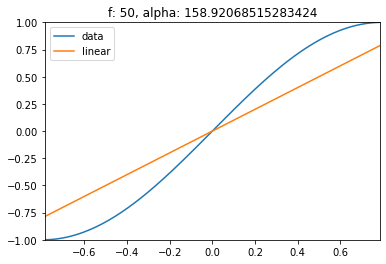

beta angle: 108.44136626084762 deg


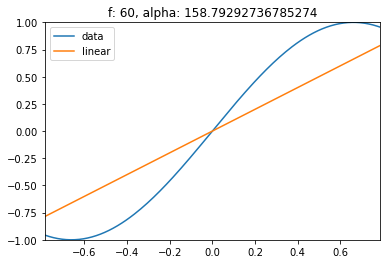

beta angle: 94.830521833176 deg


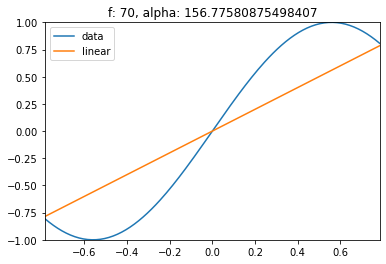

beta angle: 90.41741182876761 deg


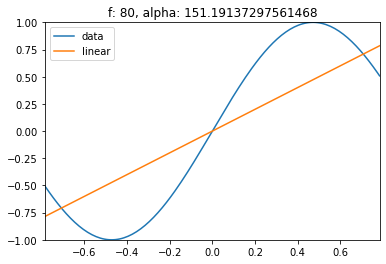

beta angle: 66.02364675830097 deg


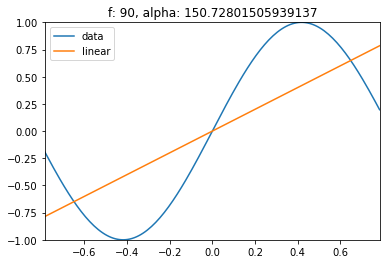

beta angle: 160.73103567526007 deg


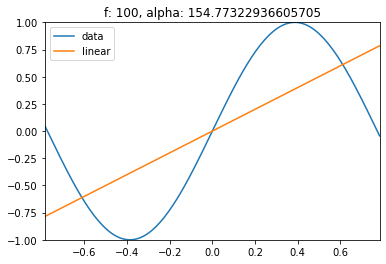

beta angle: 93.7309139790345 deg


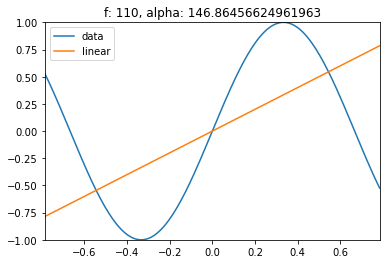

beta angle: 114.04987333969196 deg


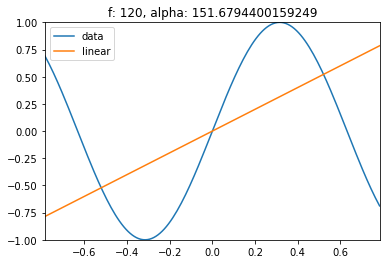

beta angle: 63.932665402225894 deg
trial: 3


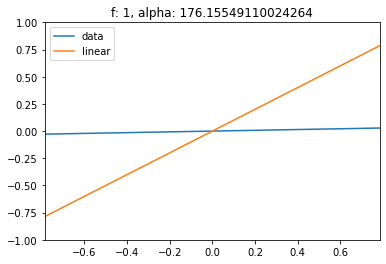

beta angle: 101.93101858362654 deg


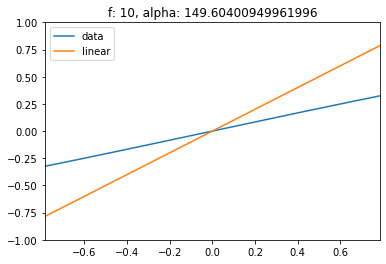

beta angle: 63.27267666729545 deg


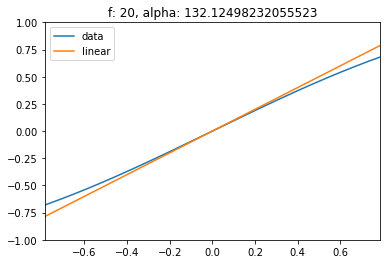

beta angle: 93.82382056741328 deg


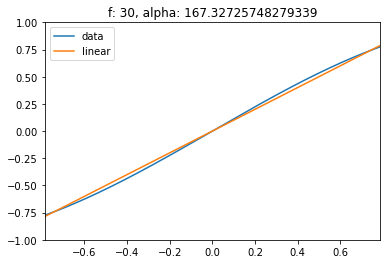

beta angle: 102.34415777290735 deg


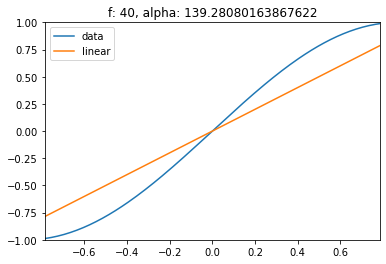

beta angle: 75.41408221814041 deg


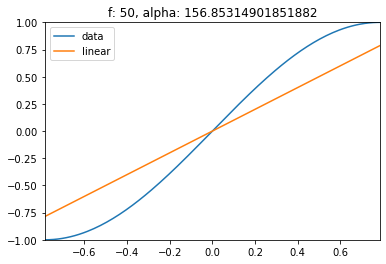

beta angle: 115.99188749956646 deg


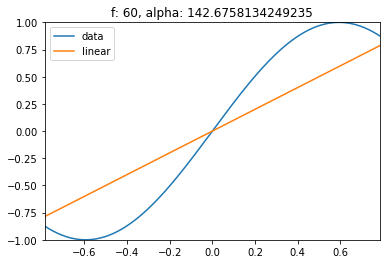

beta angle: 99.04984442777922 deg


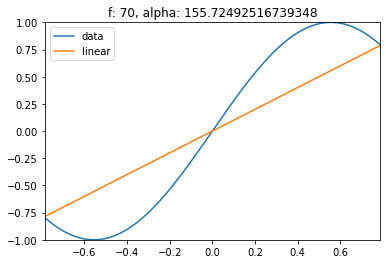

beta angle: 94.44231898845578 deg


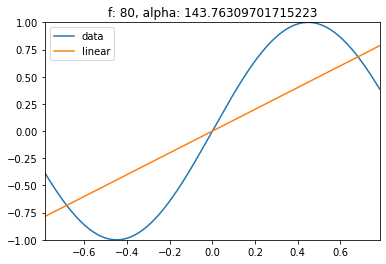

beta angle: 109.82211854173268 deg


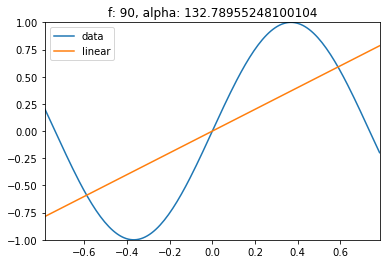

beta angle: 113.55359291468984 deg


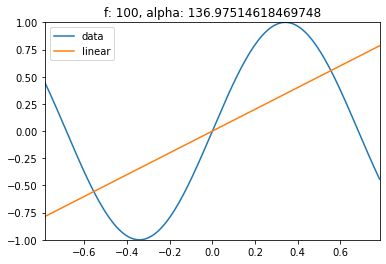

beta angle: 98.85175851083686 deg


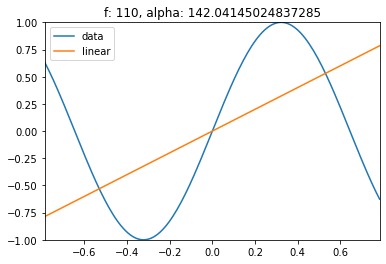

beta angle: 83.55132869604012 deg


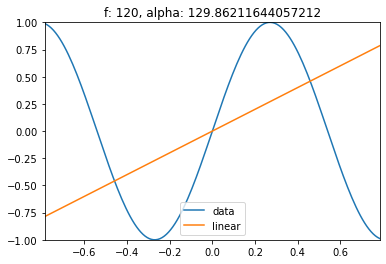

beta angle: 92.87586709785016 deg
trial: 4


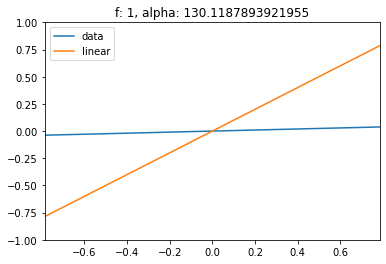

beta angle: 107.42853823740187 deg


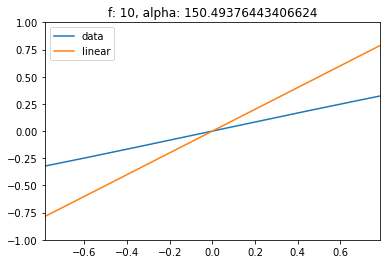

beta angle: 85.28774866509417 deg


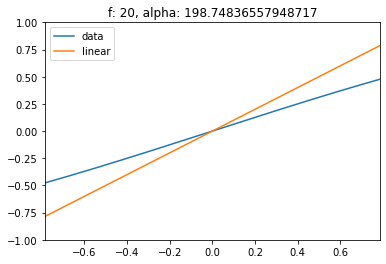

beta angle: 148.76324602494662 deg


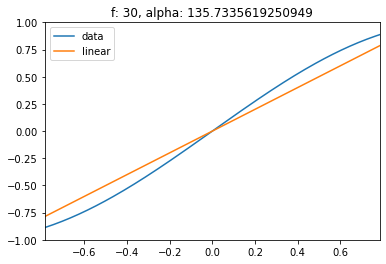

beta angle: 77.66240073622507 deg


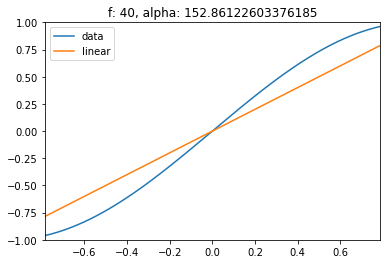

beta angle: 123.39750491079627 deg


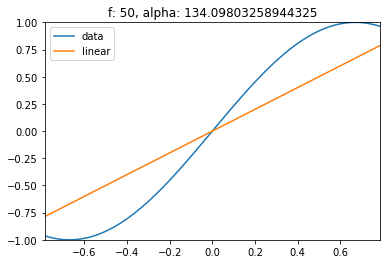

beta angle: 99.01770422506928 deg


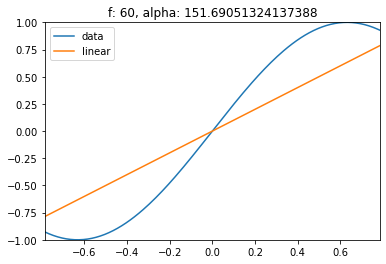

beta angle: 99.51000442486949 deg


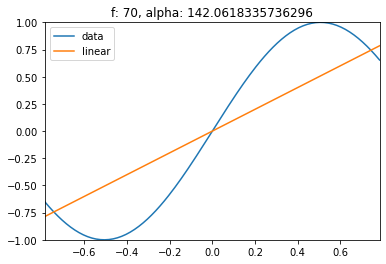

beta angle: 86.57190179765226 deg


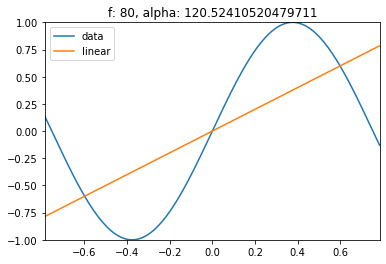

beta angle: 123.033363941906 deg


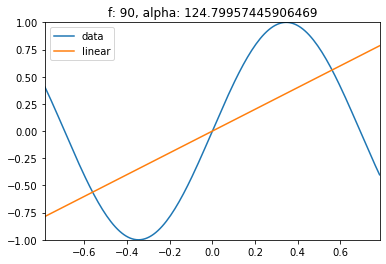

beta angle: 105.14324591205511 deg


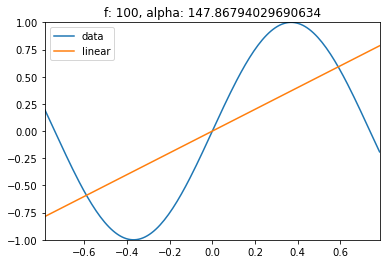

beta angle: 101.5331286606678 deg


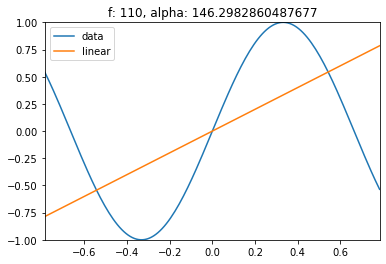

beta angle: 106.00609519549346 deg


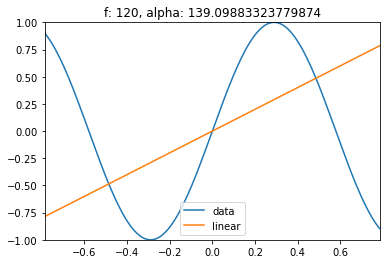

beta angle: 94.00027298636259 deg
trial: 5


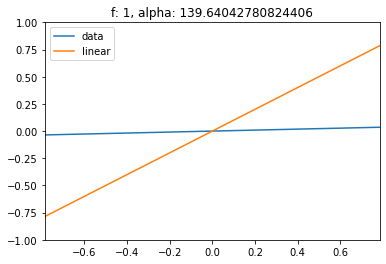

beta angle: 85.55802057416841 deg


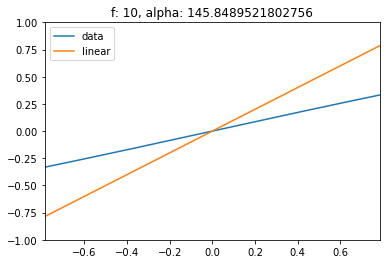

beta angle: 89.62751379217926 deg


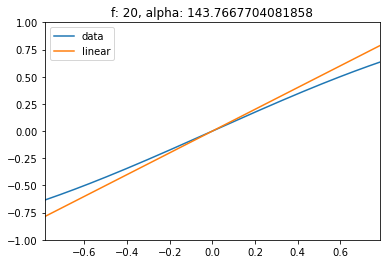

beta angle: 64.85422034106367 deg


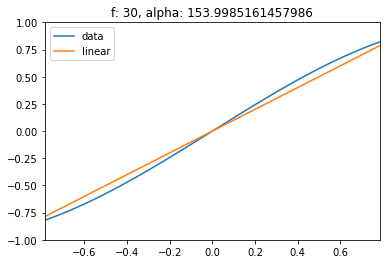

beta angle: 51.14248764611978 deg


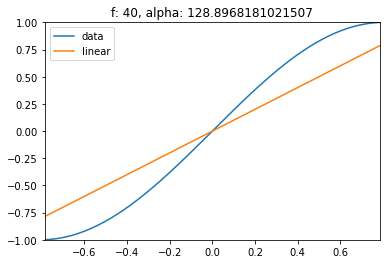

beta angle: 85.77812233307426 deg


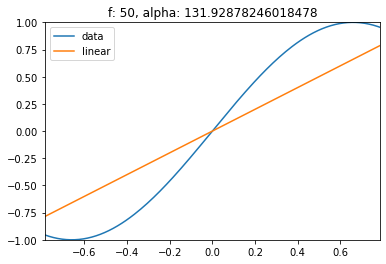

beta angle: 74.23924955055017 deg


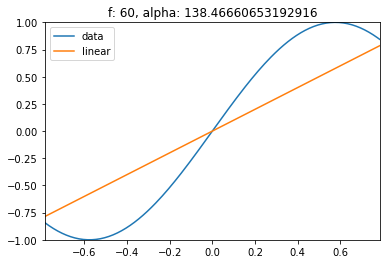

beta angle: 99.57167173676496 deg


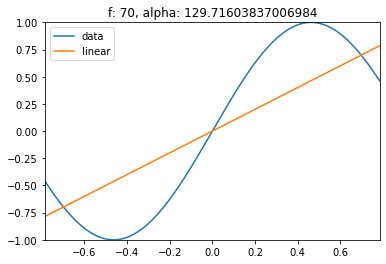

beta angle: 92.54259698376956 deg


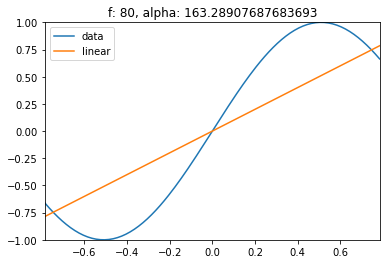

beta angle: 95.0236792698681 deg


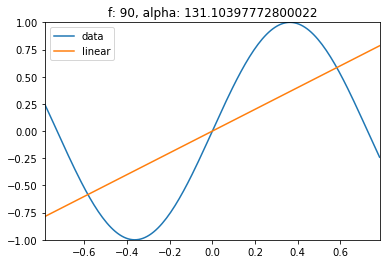

beta angle: 106.36506615724818 deg


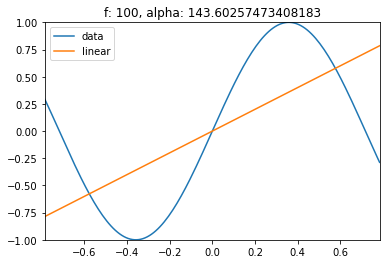

beta angle: 108.35946934357426 deg


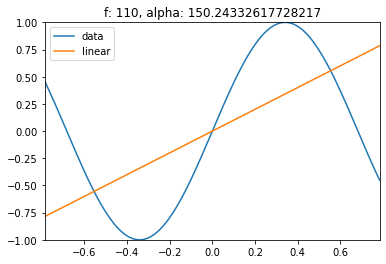

beta angle: 72.58658081479336 deg


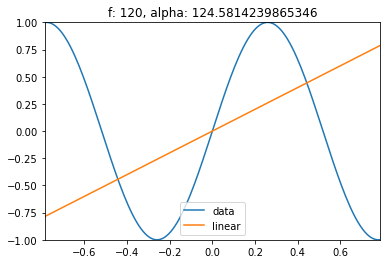

beta angle: 100.72789041269913 deg
trial: 6


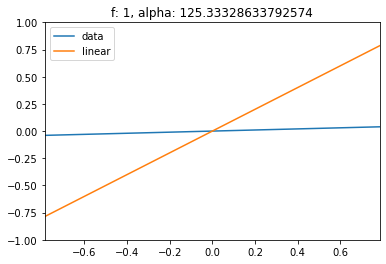

beta angle: 39.734220176542436 deg


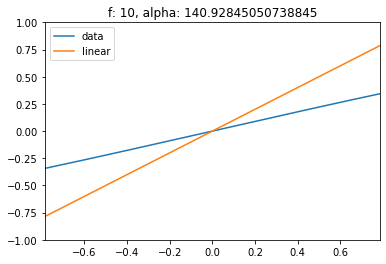

beta angle: 124.5804734387252 deg


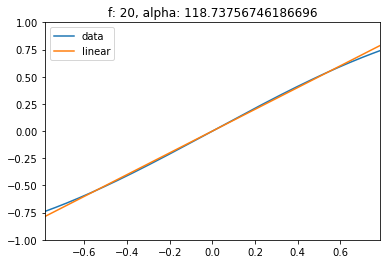

beta angle: 86.4880013179496 deg


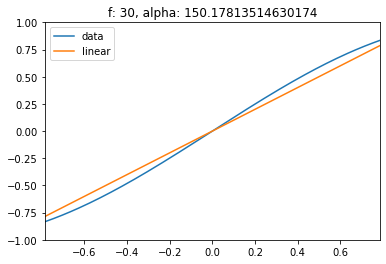

beta angle: 127.92285174112612 deg


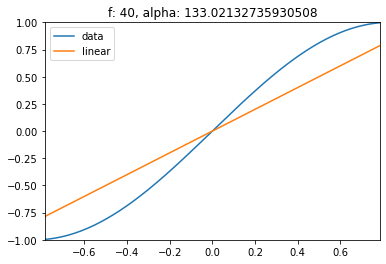

beta angle: 82.49852967011579 deg


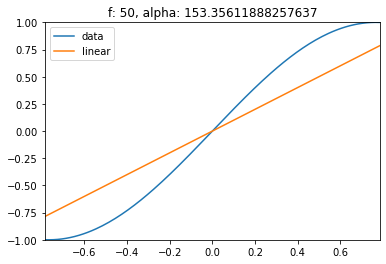

beta angle: 83.15053815118945 deg


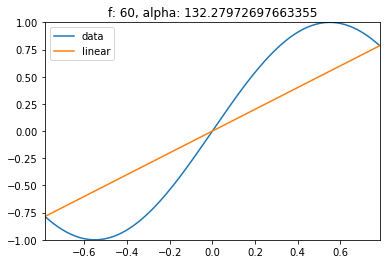

beta angle: 102.25825929517673 deg


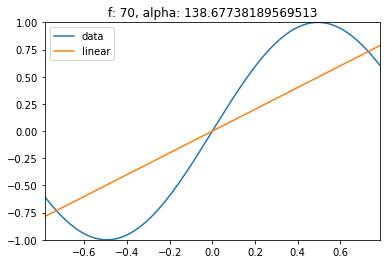

beta angle: 127.01899568620274 deg


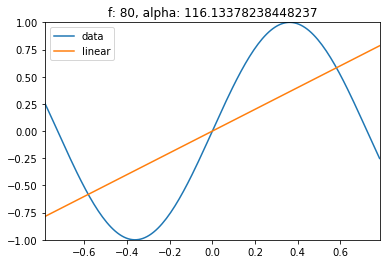

beta angle: 80.5253881373769 deg


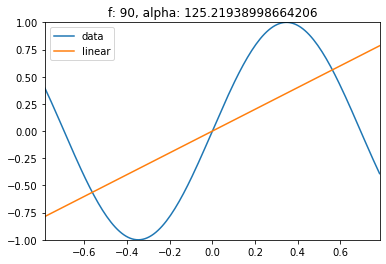

beta angle: 104.54434400836034 deg


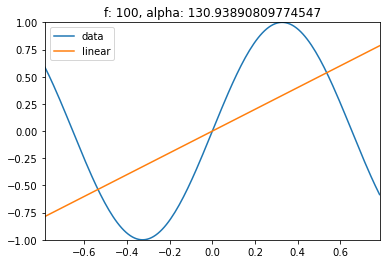

beta angle: 83.28181616753821 deg


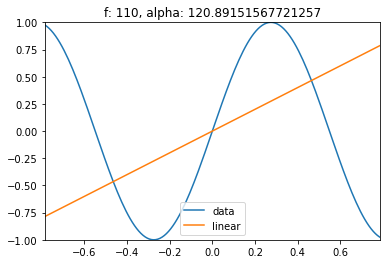

beta angle: 87.59797585505633 deg


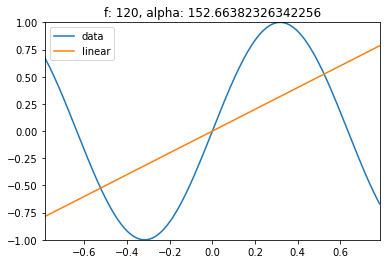

beta angle: 75.58602272069955 deg
trial: 7


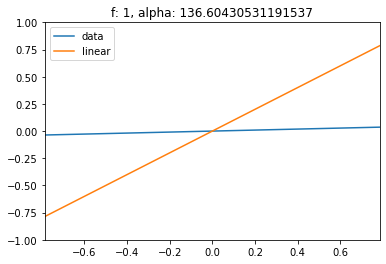

beta angle: 77.81699508564513 deg


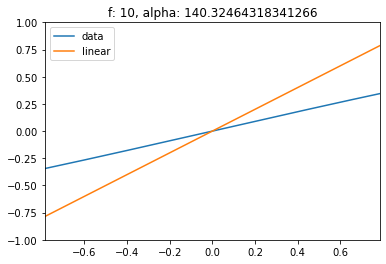

beta angle: 81.16707583362869 deg


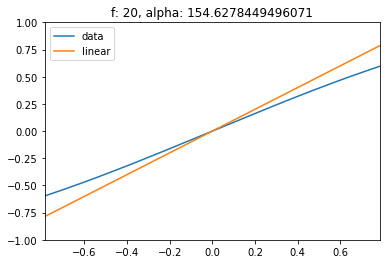

beta angle: 108.79957785004079 deg


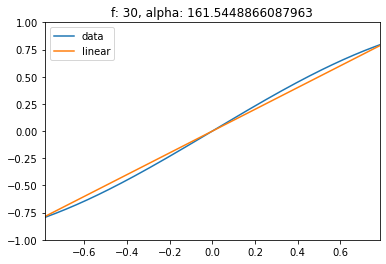

beta angle: 114.51607011139926 deg


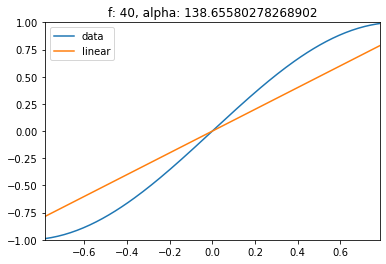

beta angle: 79.3686220221449 deg


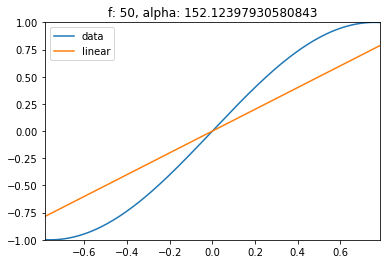

beta angle: 96.89724751801752 deg


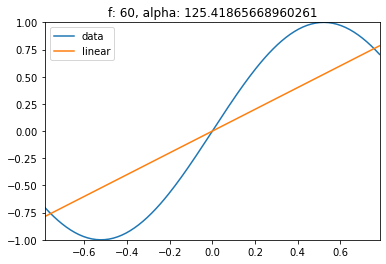

beta angle: 90.53893874584747 deg


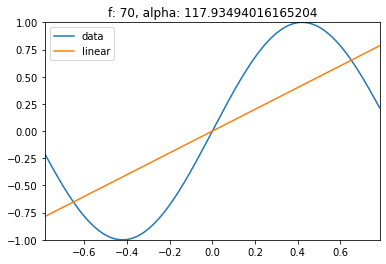

beta angle: 107.32286104244344 deg


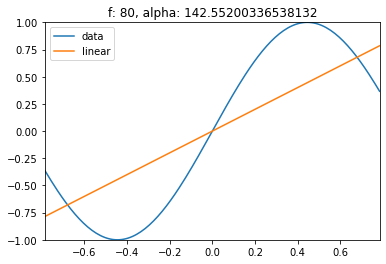

beta angle: 109.47200777619932 deg


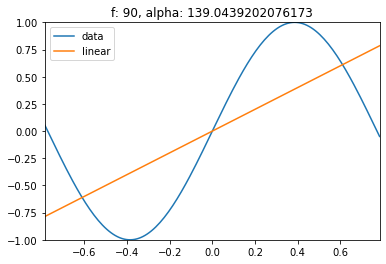

beta angle: 102.94212609455782 deg


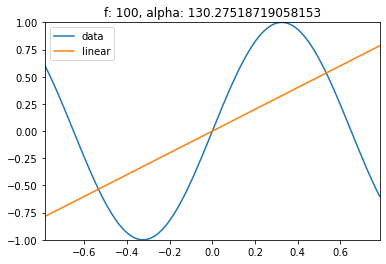

beta angle: 80.0559250325222 deg


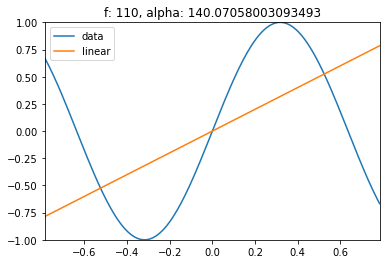

beta angle: 98.31971426911865 deg


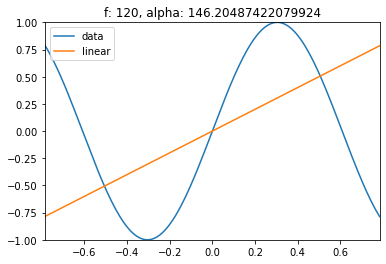

beta angle: 56.66486915173596 deg
trial: 8


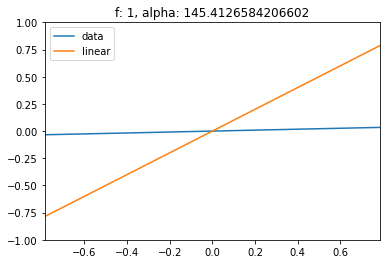

beta angle: 95.48389195385072 deg


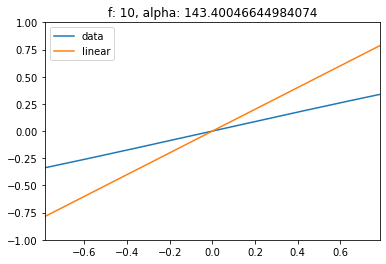

beta angle: 117.3134086863025 deg


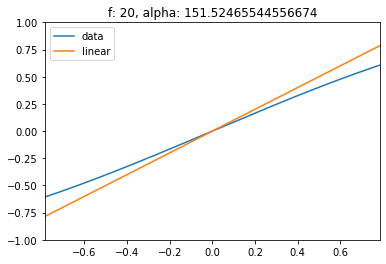

beta angle: 78.49357867832585 deg


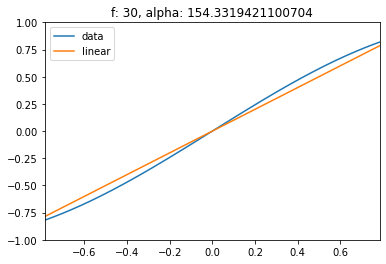

beta angle: 123.88504948264263 deg


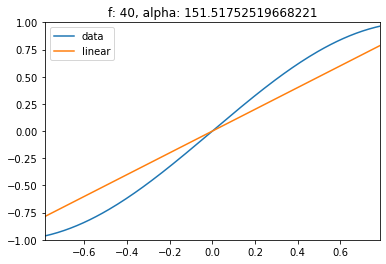

beta angle: 101.19574773887773 deg


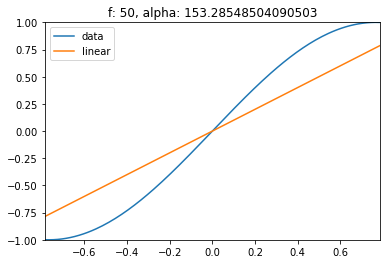

beta angle: 68.03101264573792 deg


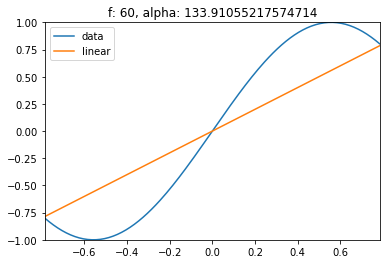

beta angle: 107.59821420806726 deg


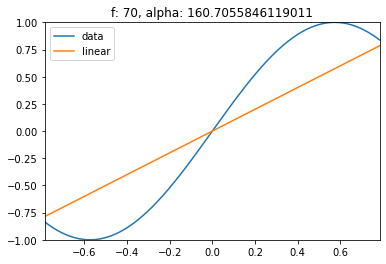

beta angle: 103.79203291589866 deg


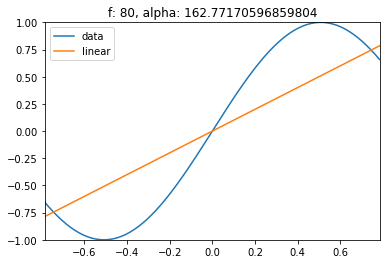

beta angle: 99.66253934296303 deg


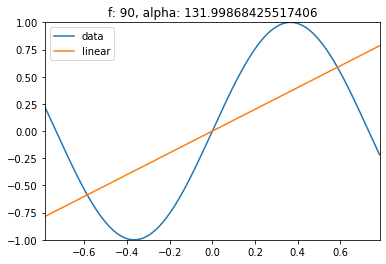

beta angle: 75.83158621763711 deg


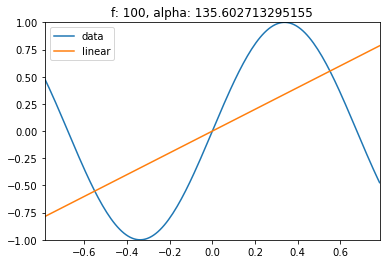

beta angle: 121.05812385920602 deg


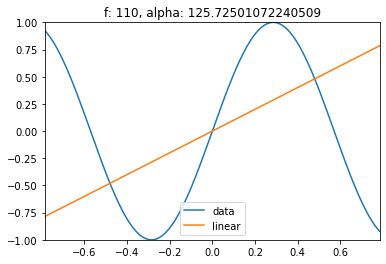

beta angle: 124.72446600727326 deg


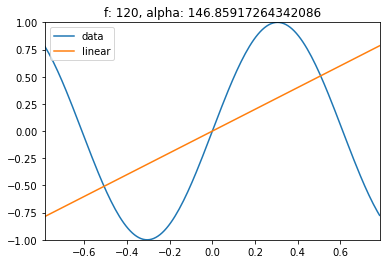

beta angle: 88.27775482575461 deg
trial: 9


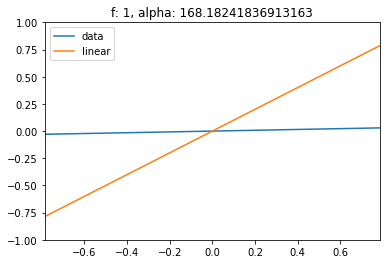

beta angle: 127.54923949443847 deg


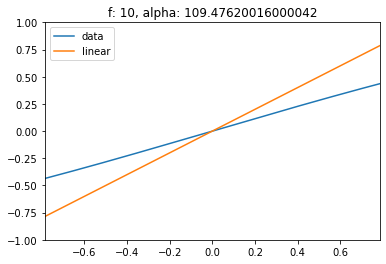

beta angle: 75.66663178181523 deg


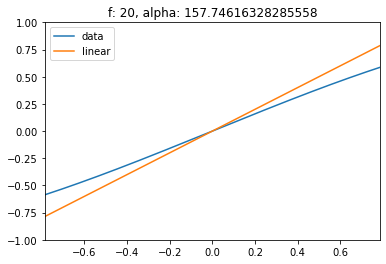

beta angle: 86.08431178302939 deg


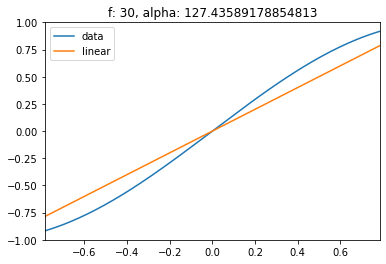

beta angle: 71.925515734962 deg


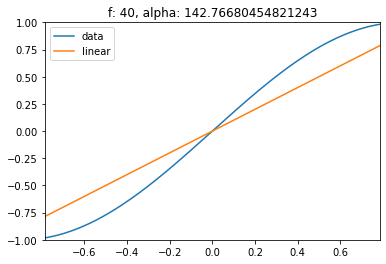

beta angle: 95.9903085017324 deg


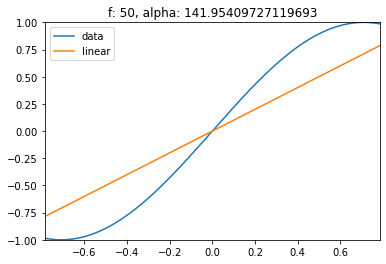

beta angle: 89.42054749804855 deg


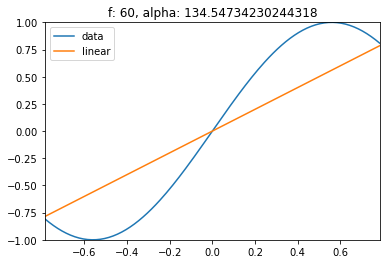

beta angle: 100.34107666798674 deg


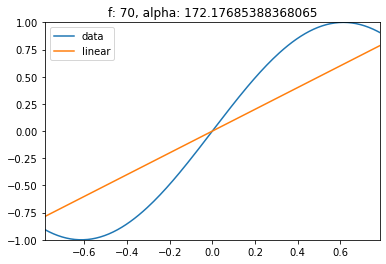

beta angle: 108.67804797490169 deg


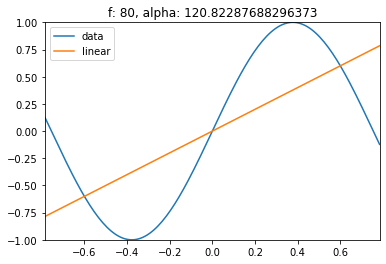

beta angle: 84.44034676561216 deg


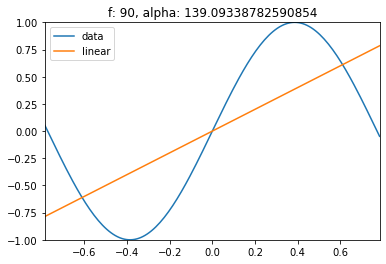

beta angle: 88.27020106384985 deg


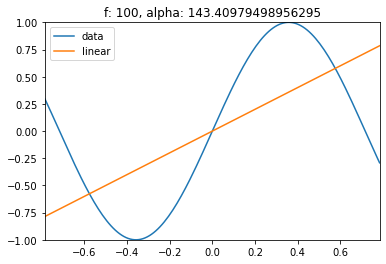

beta angle: 111.5062514511285 deg


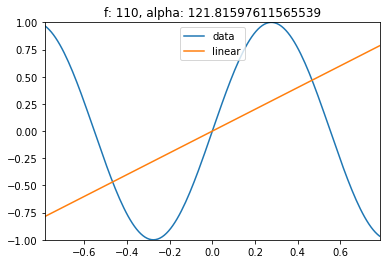

beta angle: 134.49172527957515 deg


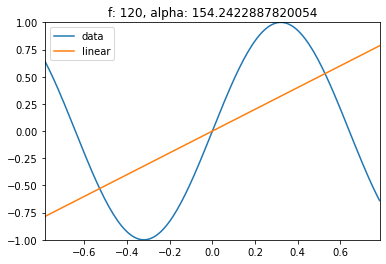

beta angle: 85.17340040296837 deg


In [22]:
N = 100 # samples
P = 5 # features
b = 2 # desired dimensionality from dimensionality reduction
trial_ct = 10
f_range = [1] + [i for i in range(10, 130, 10)] # degree of nonlinearity
beta_angles = np.zeros((trial_ct, len(f_range)))
for i in range(trial_ct):
    print(f"trial: {i}")
    for j, f in enumerate(f_range):
        X, beta, Y = generate_data(N, P, b, f)
        beta_hat, v_hat = dc.dca_grad_learn(X, Y, K=b, lr=1e-3, epsilon=1e-5)
        angle = beta_angle(beta_hat, beta)
        print(f"beta angle: {np.rad2deg(angle)} deg")
        beta_angles[i, j] = angle
with open("dca_grad_learn_betas.pickle", 'wb') as wf:
    pickle.dump(beta_angles, wf)

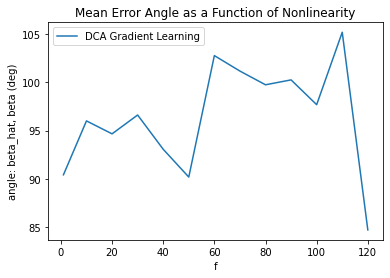

In [23]:
with open("dca_grad_learn_betas.pickle", 'rb') as rf:
    beta_angles = pickle.load(rf)
plt.plot(f_range, np.mean(np.rad2deg(beta_angles), axis=0))
plt.title("Mean Error Angle as a Function of Nonlinearity")
plt.xlabel("f")
plt.ylabel("angle: beta_hat, beta (deg)")
plt.legend(["DCA Gradient Learning"]);

## Reference figure 2A from Cowley et al. 2017

![figure 2A Cowley](fig_2A_Cowley.png "Reference Error Angle")